# Tutorial 2: Contrastive learning for object recognition

**Week 1, Day 2: Comparing Tasks**

**By Neuromatch Academy**

__Content creators:__ Andrew F. Luo, Leila Wehbe

__Content reviewers:__ Names & Surnames

__Production editors:__ Names & Surnames

<br>

Acknowledgments: [ACKNOWLEDGMENT_INFORMATION]


___


# Tutorial Objectives

*Estimated timing of tutorial: 20 minutes*

By the end of this tutorial, participants will be able to:
1. Understand why we want to do contrastive learning.
2. Understand the losses in contrastive learning.
3. Run an example on contrastive learning using MNIST.



In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today


## Uncomment the code below to test your function

#from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"

print("If you want to download the slides: 'Link to the slides'")
      # Example: https://osf.io/download/{link_id}/

#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: 'Link to the slides'


---
# Setup



In [2]:
# @title Install and import feedback gadget

# !pip3 install vibecheck datatops --quiet

# from vibecheck import DatatopsContentReviewContainer
# def content_review(notebook_section: str):
#     return DatatopsContentReviewContainer(
#         "",  # No text prompt - leave this as is
#         notebook_section,
#         {
#             "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
#             "name": "sciencematch_sm", # change the name of the course : neuromatch_dl, climatematch_ct, etc
#             "user_key": "y1x3mpx5",
#         },
#     ).render()

# feedback_prefix = "W1D2_T1"

In [3]:
# @title Install dependencies
# @markdown

!pip install numpy matplotlib torch torchvision tqdm ipysankeywidget ipywidgets

In [4]:
# @title Import dependencies
# @markdown

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set up logging
import logging
import gc

In [5]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perform high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [6]:
# @title Plotting functions
# @markdown


In [7]:
#@title Helper functions
# @markdown

## Overview of the tutorial

To begin, we will start by importing all the necessary packages that we'll need throughout our session. This initial step ensures that all the tools and functions required for our computations are readily available.

### Speeding up training and inference.

Next, let's discuss the 'allow tf32' settings in PyTorch, which are designed to enhance computational speed at the expense of precision. This setting is particularly relevant for operations involving tensors. PyTorch automatically enables this for CuDNN-based convolution operations to accelerate processing times. However, it's important to note that for matrix multiplication tasks, this option remains disabled by default to maintain higher numerical precision.

### Analysis of the results

As we move forward, we'll employ PCA (Principal Component Analysis) and t-SNE (t-Distributed Stochastic Neighbor Embedding) as our primary tools for visualizing data. These techniques are instrumental in reducing the dimensionality of the data, allowing us to observe patterns and relationships that are otherwise difficult to discern in high-dimensional spaces. By visualizing data in this way, we can gain insightful perspectives that are crucial for understanding complex datasets.

### What is contrastive learning?

Contrastive learning is often referred to as "self-supervised learning (SSL)" and has historically been known as "metric learning." The essence of contrastive/metric learning is that instead of outputting a classification one-hot/softmax vector, or a regression value, you directly output a high-dimensional embedding.

Here is an example: Given multiple data points from a single class (for example, three photos of you from different viewpoints) and different classes (for example, 10 photos from one or multiple people who are not you), you want the three embeddings from your photos to be closer to each other while being farther away from the ten embeddings from the different classes.

Hence the name "metric learning," where you seek to learn a metric/distance that fits the constraints of the data.


### Why contrastive learning?

It may not be immediately obvious why you would want to engage in contrastive/metric learning. Can't you just use a giant 1000-class ImageNet-trained classifier and recognize every image? However, metric learning proves useful when the number of classes is not known ahead of time. For example, if I wanted a network to recognize human faces, there are 7 billion people on this planet, which makes it impossible for you to train a classification network with 7 billion output neurons. Nevertheless, I can train a network that outputs a high-dimensional embedding for each image. Now, given a reference image of a person, your network can decide if the new photo is close to or farther away from the reference image.


### Terms defined and other stuff

* Positive pair—This refers to two data points that should be close together in embedding space. For example, two photos of you in different lighting conditions.
* Negative pair—This refers to two data points that should be far apart in embedding space. For example, a photo of you versus a photo of a dog (assuming you are not a dog). Note that positive pairs/negative pairs don't have to be images. You could have a picture and the matching text be a positive pair as well. Recent work has also moved to positive pairs defined using an older version of the encoder (Google Momentum contrast or EMA contrastive).
* Pretext task—In computer vision, this refers to how you augment images to get positive pairs.
Hard positive/negative mining—This refers to a practice where positive/negative pairs where the network struggles are used to train the network with more loss in some way.
* InfoNCE—This is one of the most common contrastive losses [1,2,3,4], which was proposed in similar ways multiple times by different authors. It is a cross-entropy loss of classifying the correct positive pair out from a pool of pairs. Note there are variants like MIL-NCE, which allow for multiple positive pairs.

## Getting Started

First, we'll start by outlining the network blocks that we plan to incorporate into our model. This involves defining each component as a class in PyTorch, which requires inheriting from the torch.nn.Module class. It's crucial to remember that after defining your class, you must initialize it properly by calling super().__init__(). This step is essential as it ensures that all network sub-modules are registered correctly. Additionally, PyTorch provides several useful functions such as ModuleList, register_parameter, register_module, and register_buffer to help manage these components effectively.

### Mini residual block

Our initial focus will be on creating a mini_residual block. This block adopts a modern approach to the residual design, featuring a prenormalization step as suggested by Kaiming He. We will also incorporate the LeakyReLU activation function. LeakyReLU is particularly favored in generative adversarial networks (GANs) due to its ability to maintain non-zero gradients, which helps in the training process by avoiding the vanishing gradient problem.

### Full model construction

Following the mini_residual block, we will construct the full model. This model will consist of a series of residual blocks stacked together. In PyTorch, the components of a model are organized in a sequence using nn.Sequential, which executes the blocks from the first to the last. This sequential arrangement simplifies the process of defining forward pass operations, ensuring that data flows through the blocks in the intended order. By stacking these blocks, the model can learn complex patterns from the data, enhancing its predictive performance.

In [8]:
class mini_residual(nn.Module):
    # Follows "Identity Mappings in Deep Residual Networks", uses layernorm instead of batchnorm, uses leakyReLU instead of ReLU
    def __init__(self, feat_in=128, feat_out=128, feat_hidden=256, use_norm=True):
        super().__init__()
        if use_norm:
            self.block = nn.Sequential(nn.LayerNorm(feat_in), nn.LeakyReLU(negative_slope=0.1),
                                      nn.Linear(feat_in, feat_hidden), nn.LayerNorm(feat_hidden),
                                      nn.LeakyReLU(negative_slope=0.1), nn.Linear(feat_hidden, feat_out))
        else:
            self.block = nn.Sequential(nn.LeakyReLU(negative_slope=0.1),nn.Linear(feat_in, feat_hidden),
                                      nn.LeakyReLU(negative_slope=0.1), nn.Linear(feat_hidden, feat_out))
        if feat_in!=feat_out:
            self.bypass = nn.Linear(feat_in, feat_out)
        else:
            self.bypass = nn.Identity()

    def forward(self, input_data):
        return self.block(input_data) + self.bypass(input_data)


class Model(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, num_blocks=4):
        super().__init__()
        self.in_proj = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.Sequential(*[mini_residual(feat_in=hidden_dim, feat_out=hidden_dim, feat_hidden=hidden_dim) for i in range(num_blocks)])
        self.out = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        in_proj_out = self.in_proj(x)
        hidden_out = self.hidden(in_proj_out)
        return self.out(hidden_out)

Now, let's move on to defining the loss function for our model, using an approach extracted from the PyTorch metric learning package for better clarity. We will be implementing a variant of the InfoNCE loss function, which is widely recognized as one of the most effective contrastive or metric learning losses. It has been prominently used in various models, including OpenAI's CLIP, due to its ability to enhance feature discrimination by contrasting positive pairs against negative pairs.

InfoNCE typically requires substantial batch sizes—commonly 128 or even larger—to perform optimally. This requirement is due to the need for diverse negative samples in the batch to effectively learn the contrasts. However, large batch sizes can be impractical in resource-constrained settings or when data availability is limited.

To address this, we will implement a modified version of InfoNCE as described in the "Decoupled Contrastive Learning" paper. This variant adapts the loss to be more suitable for smaller batch sizes by modifying the denominator of the InfoNCE formula. Specifically, it removes the positive example from the denominator, which reduces the computational demand and stabilizes training when fewer examples are available. This adjustment not only makes the loss function more flexible but also maintains robustness in learning discriminative features even with smaller batch sizes.

In [9]:
# This is code from the pytorch metric learning package
# Extracted out so it is clear what it is doing

def neg_inf(dtype):
    return torch.finfo(dtype).min


def small_val(dtype):
    return torch.finfo(dtype).tiny

def to_dtype(x, tensor=None, dtype=None):
    if not torch.is_autocast_enabled():
        dt = dtype if dtype is not None else tensor.dtype
        if x.dtype != dt:
            x = x.type(dt)
    return x

def get_matches_and_diffs(labels, ref_labels=None):
    if ref_labels is None:
        ref_labels = labels
    labels1 = labels.unsqueeze(1)
    labels2 = ref_labels.unsqueeze(0)
    matches = (labels1 == labels2).byte()
    diffs = matches ^ 1
    if ref_labels is labels:
        matches.fill_diagonal_(0)
    return matches, diffs

def get_all_pairs_indices(labels, ref_labels=None):
    """
    Given a tensor of labels, this will return 4 tensors.
    The first 2 tensors are the indices which form all positive pairs
    The second 2 tensors are the indices which form all negative pairs
    """
    matches, diffs = get_matches_and_diffs(labels, ref_labels)
    a1_idx, p_idx = torch.where(matches)
    a2_idx, n_idx = torch.where(diffs)
    return a1_idx, p_idx, a2_idx, n_idx

def cos_sim(input_embeddings):
    # batch, dim
    normed_embeddings = torch.nn.functional.normalize(input_embeddings, dim=-1)
    return normed_embeddings@normed_embeddings.t()

def dcl_loss(pos_pairs, neg_pairs, indices_tuple,temperature=0.07):
    # This is the modified InfoNCE loss called "Decoupled Contrastive Learning" for small batch sizes
    # Basically You remove the numerator from the sum to the denominator

    a1, p, a2, _ = indices_tuple

    if len(a1) > 0 and len(a2) > 0:
        dtype = neg_pairs.dtype
        pos_pairs = pos_pairs.unsqueeze(1) / temperature
        neg_pairs = neg_pairs / temperature
        n_per_p = to_dtype(a2.unsqueeze(0) == a1.unsqueeze(1), dtype=dtype)
        neg_pairs = neg_pairs * n_per_p
        neg_pairs[n_per_p == 0] = neg_inf(dtype)

        max_val = torch.max(
            pos_pairs, torch.max(neg_pairs, dim=1, keepdim=True)[0]
        ).detach()
        numerator = torch.exp(pos_pairs - max_val).squeeze(1)
        denominator = torch.sum(torch.exp(neg_pairs - max_val), dim=1)
        log_exp = torch.log((numerator / denominator) + small_val(dtype))
        return -log_exp
    return 0

def pair_based_loss(mat, indices_tuple, lossfunc):
    a1, p, a2, n = indices_tuple
    pos_pair, neg_pair = [], []
    if len(a1) > 0:
        pos_pair = mat[a1, p]
    if len(a2) > 0:
        neg_pair = mat[a2, n]
    return lossfunc(pos_pair, neg_pair, indices_tuple)

# dummy_labels = torch.from_numpy(np.array([1,1,2,3,2,4]))
# demo_matches, demo_diffs = get_matches_and_diffs(labels=dummy_labels)
# results = get_all_pairs_indices(labels=dummy_labels)
# final_loss = pair_based_loss(torch.randn(6,6),results, None)

Now we will make the Pytorch dataset object, this defines how data is loaded from disk for each batch, and what transform you want to apply. Note that you do not have to use torchvision transforms. It is very common to write your own transform code in the dataset object.

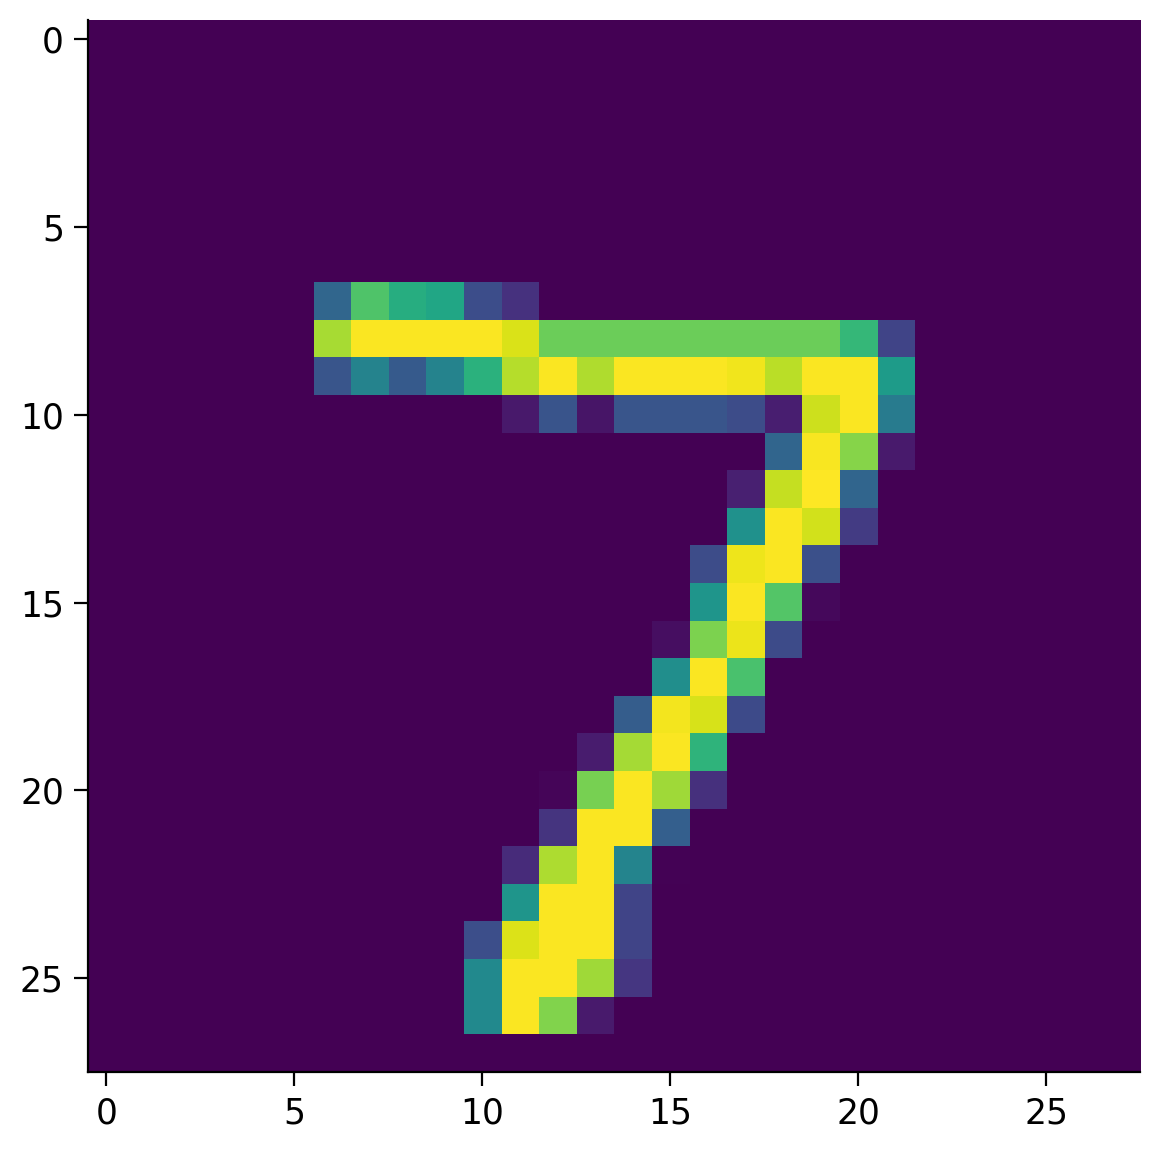

7


In [10]:
mnist_transforms=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
test_dset = torchvision.datasets.MNIST("./", train=False, transform=mnist_transforms, download=True)


height = int(784**0.5)
width = height
idx = 0
data_point = test_dset[idx]
plt.imshow(data_point[0][0].numpy())
plt.show()
print(data_point[1])

Now we will make the model using the definition we wrote previously. And we will move it to the device you want. Note that in pytorch, calling `.to(device)` on a module acts on the module itself, as in it is an inplace operation. However for pytorch tensors directly (if you don't call this function on a module) it is not inplace.

In [12]:
mynet = Model(in_dim=784, out_dim=128, hidden_dim=256)

# Automatically select the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output the device that will be used
print(f"Using device: {device}")

# Move the model to the selected device
_ = mynet.to(device)

Using device: cuda


Let us create a test dataloader, and see what the untrained network gives us in terms of representations for each number. We will compute the cosine similarity for each written character WITHIN the same class (we set the diagonal to np.nan to avoid comparing a written character to itself).

We will also compute the cosine similarity for each written character across the classes.

You should have a habit of calling `network.eval()` before evaluating a network, this is also an inplace operation. This will tell pytorch to freeze some buffers (like in batchnorm) and disable dropout.

We use `torch.inference_mode()` here, this disables gradient computation and speeds up the testing process. However this may break some features, if it fails you can replace it with `torch.no_grad()`. Note that `inference_mode` does not automatically enable `eval`!

In [ ]:
# First try with untrained network, find the cosine similarities within a class and across classes
test_loader = DataLoader(test_dset, batch_size=50, shuffle=False) # enable persistent_workers=True if more than 1 worker to save CPU
mynet.eval()
test_embeddings = []
test_labels = []
sim_matrix = np.zeros((10,10))
with torch.inference_mode():
    for data_batch in test_loader:
        test_img, test_label = data_batch
        batch_size = test_img.shape[0]
        flat = test_img.reshape(batch_size,-1).to(device, non_blocking=True)
        pred_embeddings = mynet(flat).cpu().numpy().tolist()
        test_embeddings.extend(pred_embeddings)
        test_labels.extend(test_label.numpy().tolist())

test_embeddings = np.array(test_embeddings)
test_embeddings_normed = test_embeddings/np.linalg.norm(test_embeddings, axis=1, keepdims=True)
test_labels = np.array(test_labels)


### Visualizing the cosine similarity of embeddings within the same class and across different classes before training

Ideally, you should see a very high cosine similarity for images within the same class (the diagonal), but very low cosine similarity for images not within the same class (the non-diagonal).

But since our network is untrained, *you* will see there is not much difference, this is expected as the network is untrained. If you look at the plot, there is no clear structure to the similarities.


In [ ]:
embeddings = {}
for i in [0,1,2,3,4,5,6,7,8,9]:
    embeddings[i] = test_embeddings_normed[test_labels==i]

# Within class cosine similarity:
for i in [0,1,2,3,4,5,6,7,8,9]:
    sims = embeddings[i]@embeddings[i].T
    np.fill_diagonal(sims, np.nan)
    cur_sim = np.nanmean(sims)
    sim_matrix[i,i] =  cur_sim

    print("Within class {} cosine similarity".format(cur_sim))

print("==================")
for i in [0,1,2,3,4,5,6,7,8,9]:
    for j in [0,1,2,3,4,5,6,7,8,9]:
        if i==j:
            pass
        elif i>j:
            pass
        else:
            sims = embeddings[i]@embeddings[j].T
            cur_sim = np.mean(sims)
            sim_matrix[i,j] =  cur_sim
            sim_matrix[j,i] =  cur_sim
            print("{} and {} cosine similarity {}".format(i,j, np.nanmean(sims)))

plt.imshow(sim_matrix, vmin=0.0, vmax=1.0)
plt.title("untrained network")
plt.colorbar()

Now we will train the network!

Note how we decay the learning rate, so the final learning rate will be half that of the inital learning rate. AdamW is the Adam optimizer with decoupled weight decay. A learning rate of 3e-4 and a weight decay of 1e-2 in AdamW are pretty typical. Note that weight decay in AdamW and SGD work differently in the pytorch implementations. In pytorch, the adamw weight decay is further scaled by learning rate (real weight decay = weight decay * lr) but in SGD, it is not scaled by learning rate. So in AdamW, it is common to use higher weight decay values than SGD.

Also note how we call `mynet.train()` before we start training. That sets mynet to training mode, and enables the buffers and dropout layers (if they were present in the network architecture.)

In [ ]:
epochs = 10
# Automatically select the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output the device that will be used
print(f"Using device: {device}")

train_dset = torchvision.datasets.MNIST("./", train=True, transform=mnist_transforms)
train_loader = DataLoader(train_dset, batch_size=50, shuffle=True) # enable persistent_workers=True if more than 1 worker to save CPU

try:
    del optimizer
    gc.collect()
    torch.cuda.empty_cache()
    # Nuke the optimizer from memory if students try re-running this block
except:
    pass

try:
    del mynet
    gc.collect()
    torch.cuda.empty_cache()
    # Nuke the network from memory if students try re-running this block
except:
    pass

mynet = Model(in_dim=784, out_dim=128, hidden_dim=256)
_ = mynet.to(device)

# This enables training mode, which may affect dropout and stuff
mynet.train(mode=True)
print("Is the network in training mode?", mynet.training)
init_lr = 3e-4
lr_decay_factor = 0.5
optimizer = torch.optim.AdamW(mynet.parameters(), lr=init_lr, weight_decay=1e-2)

loss_tracker = []
for epoch_id in range(1, epochs+1):
    loss_epoch_tracker = 0
    batch_counter = 0
    # decay lr to half that of initial by the end of training
    new_lrate = init_lr * (lr_decay_factor ** (epoch_id / epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lrate

    batches_in_epoch = len(train_loader)
    for data_batch in train_loader:
        optimizer.zero_grad()
        train_img, train_label = data_batch
        batch_size = train_img.shape[0]
        flat = train_img.reshape(batch_size,-1).to(device, non_blocking=True)
        train_label = train_label.to(device, non_blocking=True)
        predicted_results = mynet(flat)
        # Now to compute loss
        similarities = cos_sim(predicted_results)
        label_pos_neg = get_all_pairs_indices(train_label)
        final_loss = torch.mean(pair_based_loss(similarities, label_pos_neg, dcl_loss))

        # Compute gradients from the loss to the parameters that require a gradient
        final_loss.backward()

        # Now we use the optimizer and the gradients to change the original parameters
        optimizer.step()

        # .item() converts the CUDA tensor to a single CPU scalar.
        # Note this only works on tensors with a single value
        # Avoid calling .item() too frequently, as it involves a GPU -> CPU transfer it is slow!
        loss_cpu_number = final_loss.item()

        # We keep track of the losses here
        # This is just for human visualization, doesn't really affect training
        loss_epoch_tracker+=loss_cpu_number
        batch_counter +=1

        # Every 500 batches, we print the current epoch, batches seen for the current epoch, and the current batch loss
        if batch_counter%500 == 0:
            print("Epoch {}, Batch {}/{}, loss: {}".format(epoch_id, batch_counter, batches_in_epoch, loss_cpu_number))

    # Every epoch we print out the average loss over the epoch
    print("Epoch average loss {}".format(loss_epoch_tracker/batch_counter))
# Test mode

Let us now extract the features from the trained network!

Again, please make it a habit to set the network into eval mode.

In [ ]:
test_loader = DataLoader(test_dset, batch_size=50, shuffle=False) # enable persistent_workers=True if more than 1 worker to save CPU
mynet.eval()
test_embeddings = []
test_labels = []
with torch.inference_mode():
    for data_batch in test_loader:
        test_img, test_label = data_batch
        batch_size = test_img.shape[0]
        flat = test_img.reshape(batch_size,-1).to(device, non_blocking=True)
        pred_embeddings = mynet(flat).cpu().numpy().tolist()
        test_embeddings.extend(pred_embeddings)
        test_labels.extend(test_label.numpy().tolist())
test_labels = np.array(test_labels)
print("Feature extraction done!")

As the network was trained using infoNCE, we will normalize each feature to unit norm. PCA further expects the features to be centered and 1 std.

In [ ]:
test_embeddings = np.array(test_embeddings)
test_embeddings_normed = test_embeddings/np.linalg.norm(test_embeddings, axis=1, keepdims=True)
test_embeddings_normed = test_embeddings_normed-np.mean(test_embeddings_normed, axis=1, keepdims=True)
test_embeddings_normed = test_embeddings_normed/np.std(test_embeddings_normed, axis=1, keepdims=True)
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(test_embeddings)

For TSNE, we just normalize each feature to unit norm due to infoNCE. We will not further center.

In [ ]:
test_embeddings = np.array(test_embeddings)
test_embeddings_normed = test_embeddings/np.linalg.norm(test_embeddings, axis=1, keepdims=True)
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(test_embeddings)
# This takes like a minute, go grab a coffee or something

In [ ]:
test_labels.shape, tsne_embeddings.shape

Look at how the features for each number are distributed! Note how well separated all the embeddings for different characters are.

In [ ]:
my_embeddings = tsne_embeddings
# TSNE or PCA? TSNE is nicer to look at.

num = 0
plt.scatter(my_embeddings[test_labels==num, 0], my_embeddings[test_labels==num, 1], c="red")
num = 1
plt.scatter(my_embeddings[test_labels==num, 0], my_embeddings[test_labels==num, 1], c="green")
num = 2
plt.scatter(my_embeddings[test_labels==num, 0], my_embeddings[test_labels==num, 1], c="blue")
num = 3
plt.scatter(my_embeddings[test_labels==num, 0], my_embeddings[test_labels==num, 1], c="orange")

### Visualizing the cosine similarity AFTER training

Note now that diagonal is strongly more positive than the off-diagonal, this means within the same class, the similarity is much stronger than outside a class.


In [ ]:
test_loader = DataLoader(test_dset, batch_size=50, shuffle=False) # enable persistent_workers=True if more than 1 worker to save CPU
mynet.eval()
test_embeddings = []
test_labels = []
sim_matrix = np.zeros((10,10))
with torch.inference_mode():
    for data_batch in test_loader:
        test_img, test_label = data_batch
        batch_size = test_img.shape[0]
        flat = test_img.reshape(batch_size,-1).to(device, non_blocking=True)
        pred_embeddings = mynet(flat).cpu().numpy().tolist()
        test_embeddings.extend(pred_embeddings)
        test_labels.extend(test_label.numpy().tolist())

test_embeddings = np.array(test_embeddings)
test_embeddings_normed = test_embeddings/np.linalg.norm(test_embeddings, axis=1, keepdims=True)
test_labels = np.array(test_labels)
embeddings = {}
for i in [0,1,2,3,4,5,6,7,8,9]:
    embeddings[i] =test_embeddings_normed[test_labels==i]



# Within class cosine similarity:
for i in [0,1,2,3,4,5,6,7,8,9]:
    sims = embeddings[i]@embeddings[i].T
    np.fill_diagonal(sims, np.nan)
    cur_sim = np.nanmean(sims)
    sim_matrix[i,i] =  cur_sim

    print("Within class {} cosine similarity".format(cur_sim))

print("==================")
for i in [0,1,2,3,4,5,6,7,8,9]:
    for j in [0,1,2,3,4,5,6,7,8,9]:
        if i==j:
            pass
        elif i>j:
            pass
        else:
            sims = embeddings[i]@embeddings[j].T
            cur_sim = np.mean(sims)
            sim_matrix[i,j] =  cur_sim
            sim_matrix[j,i] =  cur_sim
            print("{} and {} cosine similarity {}".format(i,j, np.nanmean(sims)))
plt.imshow(sim_matrix, vmin=0.0, vmax=1.0)
plt.title("trained network")
plt.colorbar()

### Using the network to identify nearest neighbors in the test set.

But how do people actually use a contrastive learned network? In Person Re-ID (reidentification), you will use a network to compute the embeddings for two images, and check if the embeddings have cosine/euclidean similarity above some threshold to decide if they are the same person.

In foundation model training (CLIP), people typically fine tune the entire network or train a linear probe or small network on the last layer outputs.

Here, we will follow the person Re-ID setup, and try to find the most similar image in a test set and decide if they represent the same character!

In [ ]:
sims_all = test_embeddings_normed@test_embeddings_normed.T
np.fill_diagonal(sims_all, -1000.0)
# Set to a small value so it doesn't give us the same number for argmax

idx_to_check = 3029
best_idx = np.argmax(sims_all[idx_to_check])

plt.imshow(test_dset[idx_to_check][0][0].cpu().numpy())
plt.show()
plt.imshow(test_dset[best_idx][0][0].cpu().numpy())
plt.show()

### How is contrastive learning used in practice?

Nearly all vision foundation models (DINO and DINOv2, CLIP and all CLIP derivatives including OpenCLIP/EVA-CLIP) are trained using contrastive losses. DINO/v2 is trained on images alone, while CLIP is trained on a combination of images and text.

When only images are used, the contrastive learning loss is applied to augmentations of the same image. Examples include crops/flips/rotations of images -- when used in the way, the augmentations are called a "pretext task". Typically, augmentations of the same image are treated as instances where the embeddings should be the same. So for example, a network should recognize a photo of you, and a photo of you flipped (or brightness changed, or noise added, or changed to black and white) as a photo of the same person.

When images and text are used together as in CLIP, you have images and captions of those images -- for example the caption "A photo of a dog" may be matched to a picture of a blue heeler puppy. These captions are typicalled scraped from online sources, and collected into datasets like LAION-2B/COYO-700M/CommonCrawl. While these captions are typically not high quality, having billions of them do seem to mitigate this issue. When contrastive learning is used in this case, typically a dual encoder is used -- one for text, and one for the image. The network is trained using a loss which minimizes the distance between the correct text and image pair, while distances between incorrect text and image pairs are maximized. For example -- the caption "A photo of a dog" and the picture of the blue heeler puppy should have embeddings that are close, while the caption should be far away from a picture of a cat. Often times, normalized dot-product (cosine similarity), angular distance (Universal Sentence Encoder) euclidean distance, or squared euclidean distance are applied to compute the "distance" of the embeddings.


Referencess:

[1] Unsupervised feature learning via non-parametric
instance discrimination (2018)

[2] Representation learning with contrastive predictive coding (2018)

[3] A simple framework for contrastive learning of visual representations (2020)

[4] Improved Deep Metric Learning with Multi-class N-pair Loss Objective (2016)

[4] Noise-contrastive estimation: A new estimation principle for unnormalize
statistical models (2010)